In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import amp_pd_peptide

from scipy.optimize import minimize

def seed_everthing(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

seed_everthing(2023)

pd.set_option('display.max_columns', 200) ## 모든 열 출력
pd.set_option('display.max_rows', 200) ## 모든 행 출력



In [2]:
def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)



In [3]:
target_col = ['updrs_1','updrs_2','updrs_3','updrs_4']
train_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
train_clinical_data['source'] = 'standard'
# train_clinical_data[target_col] = train_clinical_data[target_col].apply(np.log1p)

supplemental_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
supplemental_clinical_data['source'] = 'supplemental'
# supplemental_clinical_data[target_col] = supplemental_clinical_data[target_col].apply(np.log1p)

train_clinical_all = pd.concat([train_clinical_data, supplemental_clinical_data])

In [4]:
# delete visit_month 3, 5, 9 (there are no such visit_months in the Test API)
train_clinical_all = train_clinical_all[~train_clinical_all.visit_month.isin([3, 5, 9])]

<AxesSubplot:xlabel='visit_month'>

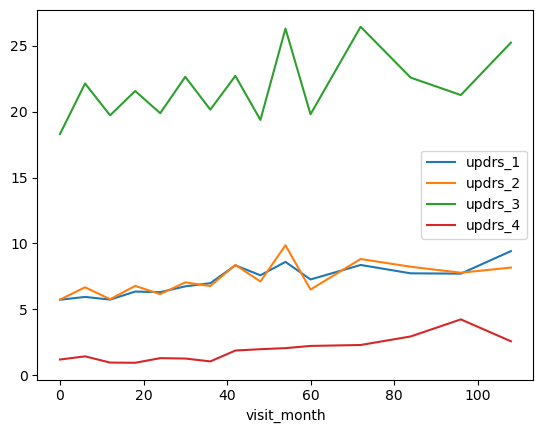

In [5]:
train_clinical_all.groupby('visit_month')[target_col].mean().plot()

In [6]:
train_clinical_all.groupby("visit_month")[target_col].describe()

updrs_1                                                  updrs_2  \
              count      mean       std  min   25%  50%    75%   max   count   
visit_month                                                                    
0             924.0  5.725108  4.452248  0.0  2.00  5.0   8.00  27.0   924.0   
6             440.0  5.938636  4.956150  0.0  2.00  5.0   8.00  33.0   440.0   
12            478.0  5.736402  4.611258  0.0  2.00  5.0   8.00  28.0   478.0   
18            363.0  6.344353  4.819377  0.0  3.00  5.0   9.00  28.0   363.0   
24            437.0  6.304348  4.952648  0.0  2.00  5.0   9.00  25.0   437.0   
30            396.0  6.739899  4.955552  0.0  3.00  6.0  10.00  27.0   395.0   
36            484.0  6.981405  5.147279  0.0  3.00  6.0  10.00  27.0   484.0   
42            153.0  8.339869  5.694138  0.0  4.00  7.0  12.00  29.0   153.0   
48            196.0  7.581633  6.203264  0.0  3.00  6.0  11.00  28.0   196.0   
54            110.0  8.600000  6.496576  0.0  4.00  7.0  12.00  31.0   110.0   
60            166.0  7.265060  6.097360  0.0  3.00  5.0   9.00  31.0   166.0   
72             93.0  8.365591  5.400855  0.0  5.00  7.0  11.00  26.0    93.0   
84            100.0  7.730000  5.644082  0.0  4.00  6.5  10.00  28.0   100.0   
96             58.0  7.706897  5.556752  0.0  4.00  7.0  11.75  23.0    58.0   
108            12.0  9.416667  8.836477  1.0  4.75  5.5  12.75  31.0    12.0   

                                                             updrs_3  \
                 mean       std  min   25%  50%    75%   max   count   
visit_month                                                            
0            5.734848  5.161743  0.0  2.00  4.0   8.00  34.0  1017.0   
6            6.670455  5.233765  0.0  3.00  6.0  10.00  28.0   438.0   
12           5.765690  5.046899  0.0  2.00  5.0   9.00  24.0   476.0   
18           6.776860  5.325568  0.0  2.00  6.0  10.00  25.0   361.0   
24           6.153318  5.431122  0.0  2.00  5.0   9.00  30.0   433.0   
30           7.043038  5.539949  0.0  3.00  6.0  11.00  26.0   395.0   
36           6.764463  5.717133  0.0  2.00  5.0  10.00  26.0   481.0   
42           8.372549  6.672688  0.0  3.00  7.0  13.00  26.0   154.0   
48           7.112245  7.147361  0.0  0.75  5.0  11.00  28.0   193.0   
54           9.863636  7.165766  0.0  4.25  9.0  14.00  39.0   109.0   
60           6.500000  6.967239  0.0  0.00  5.0  11.00  40.0   166.0   
72           8.817204  6.109412  0.0  4.00  8.0  13.00  27.0    91.0   
84           8.230000  7.788693  0.0  1.00  8.0  13.25  36.0    95.0   
96           7.775862  8.117650  0.0  0.00  6.0  15.00  27.0    56.0   
108          8.166667  9.093787  0.0  0.00  6.5  14.50  28.0    12.0   

                                                                 updrs_4  \
                  mean        std  min    25%   50%    75%   max   count   
visit_month                                                                
0            18.312684  12.375385  0.0  10.00  18.0  26.00  66.0   445.0   
6            22.143836  11.905418  0.0  14.00  21.0  31.00  56.0   124.0   
12           19.726891  13.349433  0.0  10.00  19.0  28.00  68.0   259.0   
18           21.576177  12.560758  0.0  12.00  21.0  31.00  69.0   261.0   
24           19.889145  14.085115  0.0   9.00  19.0  29.00  69.0   306.0   
30           22.650633  12.320981  0.0  14.00  22.0  30.00  67.0   326.0   
36           20.160083  13.916917  0.0  10.00  18.0  30.00  67.0   420.0   
42           22.720779  14.128494  0.0  12.25  23.0  30.75  68.0   137.0   
48           19.378238  16.538684  0.0   3.00  19.0  33.00  78.0   136.0   
54           26.311927  13.861549  0.0  16.00  26.0  34.00  86.0    98.0   
60           19.807229  17.648389  0.0   2.00  17.0  32.00  85.0   110.0   
72           26.450549  15.279081  0.0  14.50  29.0  38.50  56.0    83.0   
84           22.589474  18.387956  0.0   4.00  21.0  36.50  66.0    65.0   
96           21.267857  21.044102  0.0   1.00  19.5  36.75

In [7]:
# 중앙값
target_columns_clinical_data = ['updrs_1']
target_columns_clinical_and_supplemental_data = ['updrs_2', 'updrs_3', 'updrs_4']

target_visit_month_medians_clinical_data = train_clinical_data.groupby('visit_month')[target_columns_clinical_data].median()
target_visit_month_medians_clinical_and_supplemental_data = pd.concat((
    train_clinical_data,
    supplemental_clinical_data
), axis=0).groupby('visit_month')[target_columns_clinical_and_supplemental_data].median()

target_visit_month_medians = pd.concat((
    target_visit_month_medians_clinical_data,
    target_visit_month_medians_clinical_and_supplemental_data
), axis=1, ignore_index=False)

target_visit_month_medians = target_visit_month_medians.drop(5)
target_visit_month_medians = target_visit_month_medians.drop(3)
target_visit_month_medians = target_visit_month_medians.drop(9)

target_visit_month_medians = target_visit_month_medians.expanding(min_periods=1).max()
target_visit_month_medians = target_visit_month_medians.reset_index()
target_visit_month_medians

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,0,4.5,4.0,18.0,0.0
1,6,6.0,6.0,21.0,0.0
2,12,6.0,6.0,21.0,0.0
3,18,6.0,6.0,21.0,0.0
4,24,6.0,6.0,21.0,0.0
5,30,7.0,6.0,22.0,0.0
6,36,7.0,6.0,22.0,0.0
7,42,7.0,7.0,23.0,0.0
8,48,7.0,7.0,23.0,0.0
9,54,7.0,9.0,26.0,0.0


In [8]:
# weights
target_columns_clinical_data = ['updrs_1']
target_columns_clinical_and_supplemental_data = ['updrs_2', 'updrs_3', 'updrs_4']

target_visit_month_medians_clinical_data = train_clinical_data.groupby('visit_month')[target_columns_clinical_data].median()
target_visit_month_medians_clinical_and_supplemental_data = pd.concat((
    train_clinical_data,
    supplemental_clinical_data
), axis=0).groupby('visit_month')[target_columns_clinical_and_supplemental_data].median()

target_weight = pd.concat((
    target_visit_month_medians_clinical_data,
    target_visit_month_medians_clinical_and_supplemental_data
), axis=1, ignore_index=False)

target_weight = target_weight.drop(5)
target_weight = target_weight.drop(3)
target_weight = target_weight.drop(9)


# target_weight = target_weight.expanding(min_periods=1).max()
# target_weight = target_weight.reset_index()
# target_weight['updrs_4'] = target_weight['updrs_4'].apply(lambda x: 0.1 if x == 0.0 else x)
# updrs_4_value = target_weight['updrs_4'].copy()

target_weight[target_col] = (target_weight[target_col] / target_weight[target_col].iloc[0])
target_weight = target_weight.reset_index()
# target_weight.loc[:,'updrs_4'] = list(updrs_4_value)
target_weight['updrs_4'] = 1.0
# target_weight['updrs_4'] = (target_weight['updrs_4'] / target_weight['updrs_4'].iloc[0])
target_weight

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,0,1.000000,1.000,1.000000,1.0
1,6,1.333333,1.500,1.166667,1.0
2,12,1.111111,1.250,1.055556,1.0
3,18,1.333333,1.500,1.166667,1.0
4,24,1.333333,1.250,1.055556,1.0
5,30,1.555556,1.500,1.222222,1.0
6,36,1.333333,1.250,1.000000,1.0
7,42,1.555556,1.750,1.277778,1.0
8,48,1.333333,1.250,1.055556,1.0
9,54,1.555556,2.250,1.444444,1.0


In [9]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift['month_offset'] = train_shift['visit_month'] + plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,source,pred_month_plus_0,pred_month_plus_6,updrs_1_plus_6,updrs_2_plus_6,updrs_3_plus_6,updrs_4_plus_6,month_offset_x,pred_month_plus_12,updrs_1_plus_12,updrs_2_plus_12,updrs_3_plus_12,updrs_4_plus_12,month_offset_y,pred_month_plus_24,updrs_1_plus_24,updrs_2_plus_24,updrs_3_plus_24,updrs_4_plus_24,month_offset
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,standard,0,6.0,8.0,10.0,34.0,NaN,6.0,12.0,10.0,10.0,41.0,0.0,12.0,24.0,16.0,9.0,49.0,0.0,24.0
1,55_6,55,6,8.0,10.0,34.0,NaN,NaN,standard,6,12.0,10.0,10.0,41.0,0.0,12.0,18.0,7.0,13.0,38.0,0.0,18.0,30.0,14.0,13.0,49.0,0.0,30.0
2,55_12,55,12,10.0,10.0,41.0,0.0,On,standard,12,18.0,7.0,13.0,38.0,0.0,18.0,24.0,16.0,9.0,49.0,0.0,24.0,36.0,17.0,18.0,51.0,0.0,36.0
3,55_18,55,18,7.0,13.0,38.0,0.0,On,standard,18,24.0,16.0,9.0,49.0,0.0,24.0,30.0,14.0,13.0,49.0,0.0,30.0,42.0,12.0,20.0,41.0,0.0,42.0
4,55_24,55,24,16.0,9.0,49.0,0.0,On,standard,24,30.0,14.0,13.0,49.0,0.0,30.0,36.0,17.0,18.0,51.0,0.0,36.0,48.0,17.0,16.0,52.0,0.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501,65303_36,65303,36,4.0,1.0,26.0,0.0,NaN,supplemental,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4502,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN,supplemental,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4503,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN,supplemental,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4504,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN,supplemental,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# train_clinical_all["updrs_12_max"] = train_clinical_all[['updrs_1','updrs_2']].apply(lambda x : np.max(x),axis=1)

In [11]:
# train_clinical_all["updrs_12_mean"] = train_clinical_all[['updrs_1','updrs_2']].apply(lambda x : np.round(np.mean(x)),axis=1)

In [12]:
# train_clinical_all.groupby('visit_month')[target_col + ["updrs_12_max","updrs_12_mean"]].mean().plot()

In [13]:
def calculate_predictions(pred_month, trend, target):
    if target == 'updrs_4': 
        pred_month = pred_month.clip(54,None)
        return np.round((trend[0]) + pred_month * (trend[1]))
    elif target == "updrs_1":
        pred_month = pred_month.clip(2, None) # 42
        return np.round((trend[0]) + pred_month * (trend[1]))
    elif target == 'updrs_2':
        pred_month = pred_month.clip(2, None)
        return np.round((trend[0]) + pred_month * (trend[1]))
    elif target == "updrs_3":
        pred_month = pred_month.clip(2, None) # 83
        return np.round((trend[0]) + pred_month * (trend[1]))

def function_to_minimize(x):    
    metric = smape_plus_1(
        y_true=y_true_array, 
        y_pred=calculate_predictions(
            pred_month=pred_month_array,
            trend=x,
            target=target
        )
    )
    return metric

target_to_trend = {}
for i in range(1, 5):
    target = f'updrs_{i}'
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
#     columns_with_visit_month = [f'visit_month' for i in range(4)]
#     display(train_clinical_all[columns_with_pred_month].values.ravel())
#     visit_month_array = train_clinical_all[columns_with_visit_month].values.ravel()
    y_true_array = train_clinical_all[columns_with_target].values.ravel()
    pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
#     display(pred_month_array.shape)
#     display(visit_month_array.shape)
    trend = list(minimize(
        fun=function_to_minimize,
        x0=[0, 0.0048],
        method='Powell'
    ).x)
    target_to_trend[target] = trend
   
    
target_to_trend

{'updrs_1': [5.085658338606598, 0.03412475104955939],
 'updrs_2': [5.359852200747447, 0.031143420111663673],
 'updrs_3': [21.38532421935566, 0.08563255211442955],
 'updrs_4': [-4.434453480103724, 0.07531448585334258]}

`target_to_trend` is our "model" which basically consists of the best linear model (`pred_month` as the only feature) for our train data for each **y_true** (updrs_1, updrs_2, updrs_3, updrs_4).

# Validation


In [14]:
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

sum_score = []
for target_column in target_columns:
    scores = []
    for plus_month in [0,6,12,24]:
        target = f"{target_column}"
        target_idx = train_clinical_all[f"{target}_plus_{plus_month}"].notna()
        df_train = train_clinical_all.loc[target_idx]
        pred_months = df_train['visit_month'] + plus_month
        print(f'Target: {target_column} Dataset Shape: {df_train.shape}')


        linear_rate = calculate_predictions(
                pred_month=pred_months,
                trend=target_to_trend[target],
                target=target
            )

        scores.append(smape_plus_1(df_train[f"{target}_plus_{plus_month}"], linear_rate))
    mean_score = np.mean(scores)
    sum_score.append(mean_score)
    print(f'Validation SMAPE: {mean_score:.4f}\n')
print(f"Sum Validation SMAPE: {np.mean(sum_score):.4f}")

# updrs_1 clip(2, 42) 54.9043 -> 54.8793(42) ->
# updrs_2 clip(2, ) 64.8742 ->
# updrs_3 clip(2,83)  58.2730 -> 58.2469
# updrs_3 clip(2,83) + (trend[1]+0.5) 58.2469 -> 58.2243
# updrs_3 clip(2,83) + (trend[1]+0.5) + (trend[0]+0.5) 58.2243 -> 58.2129
# updrs_4 clip(54,) 42.5072 ->

# 55.1269 -> 55.1232

Target: updrs_1 Dataset Shape: (4410, 28)
Target: updrs_1 Dataset Shape: (2568, 28)
Target: updrs_1 Dataset Shape: (2640, 28)
Target: updrs_1 Dataset Shape: (1889, 28)
Validation SMAPE: 54.9043

Target: updrs_2 Dataset Shape: (4409, 28)
Target: updrs_2 Dataset Shape: (2567, 28)
Target: updrs_2 Dataset Shape: (2639, 28)
Target: updrs_2 Dataset Shape: (1888, 28)
Validation SMAPE: 64.8742

Target: updrs_3 Dataset Shape: (4477, 28)
Target: updrs_3 Dataset Shape: (2552, 28)
Target: updrs_3 Dataset Shape: (2616, 28)
Target: updrs_3 Dataset Shape: (1869, 28)
Validation SMAPE: 58.2730

Target: updrs_4 Dataset Shape: (2807, 28)
Target: updrs_4 Dataset Shape: (1787, 28)
Target: updrs_4 Dataset Shape: (1905, 28)
Target: updrs_4 Dataset Shape: (1440, 28)
Validation SMAPE: 42.5072

Sum Validation SMAPE: 55.1397


In [15]:
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

sum_score = []
for target_column in target_columns:
    scores = []
    for plus_month in [0,6,12,24]:
        target = f"{target_column}"
        target_idx = train_clinical_all[f"{target}_plus_{plus_month}"].notna()
        df_train = train_clinical_all.loc[target_idx]
        pred_months = df_train['visit_month'] + plus_month
        print(f'Target: {target_column} Dataset Shape: {df_train.shape}')


        linear_rate = calculate_predictions(
                pred_month=pred_months,
                trend=target_to_trend[target],
                target=target
            )

        scores.append(smape_plus_1(df_train[f"{target}_plus_{plus_month}"], linear_rate))
    mean_score = np.mean(scores)
    sum_score.append(mean_score)
    print(f'Validation SMAPE: {mean_score:.4f}\n')
print(f"Sum Validation SMAPE: {np.mean(sum_score):.4f}")
 

Target: updrs_1 Dataset Shape: (4410, 28)
Target: updrs_1 Dataset Shape: (2568, 28)
Target: updrs_1 Dataset Shape: (2640, 28)
Target: updrs_1 Dataset Shape: (1889, 28)
Validation SMAPE: 54.9043

Target: updrs_2 Dataset Shape: (4409, 28)
Target: updrs_2 Dataset Shape: (2567, 28)
Target: updrs_2 Dataset Shape: (2639, 28)
Target: updrs_2 Dataset Shape: (1888, 28)
Validation SMAPE: 64.8742

Target: updrs_3 Dataset Shape: (4477, 28)
Target: updrs_3 Dataset Shape: (2552, 28)
Target: updrs_3 Dataset Shape: (2616, 28)
Target: updrs_3 Dataset Shape: (1869, 28)
Validation SMAPE: 58.2730

Target: updrs_4 Dataset Shape: (2807, 28)
Target: updrs_4 Dataset Shape: (1787, 28)
Target: updrs_4 Dataset Shape: (1905, 28)
Target: updrs_4 Dataset Shape: (1440, 28)
Validation SMAPE: 42.5072

Sum Validation SMAPE: 55.1397


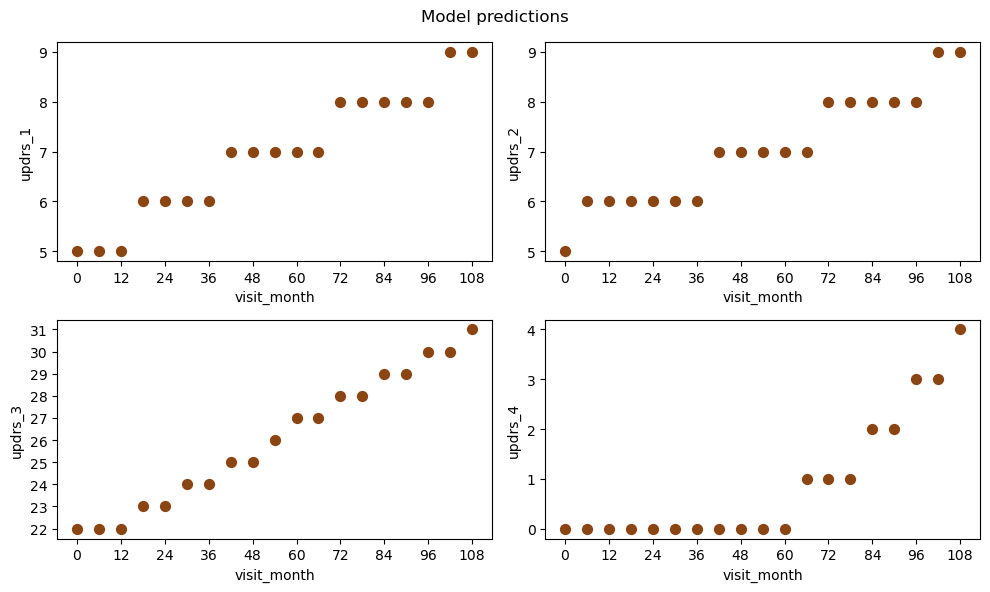

In [16]:
# pred plot
plt.figure(figsize=(10, 6))
plt.suptitle('Model predictions')
for i in range(1, 5):
    target = f'updrs_{i}'
    plt.subplot(2, 2, i)
    plt.scatter(np.arange(0, 109, 6),
                calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target),
                color='saddlebrown', s=50)
    plt.xticks(np.linspace(0, 108, 10))
    plt.ylabel(f'updrs_{i}')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('visit_month')
plt.tight_layout()
plt.show()

# Prediction

In [17]:
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

# The API will deliver four dataframes in this specific order:
for test_clinical_data, test_peptides, test_proteins, sample_submission in iter_test:
    sample_submission['patient_id'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[0]))
    sample_submission['visit_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[1]))
    sample_submission['target_name'] = sample_submission['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
    sample_submission['plus_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[5]))
    sample_submission['pred_month'] = sample_submission['visit_month'] + sample_submission['plus_month']
    
    for i in range(1, 5):
        target = f'updrs_{i}'
        mask_target = sample_submission['target_name'] == target
    
        pred_months = sample_submission.loc[mask_target, 'pred_month'].values
        
        # linear rate
        linear_rate = calculate_predictions(
            pred_month=pred_months,
            trend=target_to_trend[target],
            target=target
        ) 
        # median rate
#         median_missing_idxs = np.array([np.argmin(np.abs( pred_month - target_visit_month_medians['visit_month'])) for pred_month in pred_months])
#         median_rate = np.array([target_visit_month_medians.iloc[idx][f'{target}'] for idx in median_missing_idxs])
        
#         weight rate
#         weight_missing_idxs = np.array([np.argmin(np.abs( pred_month - target_weight['visit_month'])) for pred_month in pred_months])
#         weight_rate =  linear_rate * np.array([target_weight.iloc[idx][f'{target}'] for idx in weight_missing_idxs])
        
#         display(np.round((linear_rate + median_rate) / 2))
        
        sample_submission.loc[mask_target, 'rating'] = np.round(linear_rate)
#         sample_submission.loc[mask_target, 'rating'] = np.round((linear_rate + median_rate) / 2)
#         sample_submission.loc[mask_target, 'rating'] = np.round((linear_rate + median_rate + weight_rate) / 3)
    # call env.predict for every iteration
    env.predict(sample_submission[['prediction_id', 'rating']])
    
    display(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,prediction_id,rating,patient_id,visit_month,target_name,plus_month,pred_month
0,3342_0_updrs_1_plus_0_months,5.0,3342,0,updrs_1,0,0
1,3342_0_updrs_1_plus_6_months,5.0,3342,0,updrs_1,6,6
2,3342_0_updrs_1_plus_12_months,5.0,3342,0,updrs_1,12,12
3,3342_0_updrs_1_plus_24_months,6.0,3342,0,updrs_1,24,24
4,3342_0_updrs_2_plus_0_months,5.0,3342,0,updrs_2,0,0
5,3342_0_updrs_2_plus_6_months,6.0,3342,0,updrs_2,6,6
6,3342_0_updrs_2_plus_12_months,6.0,3342,0,updrs_2,12,12
7,3342_0_updrs_2_plus_24_months,6.0,3342,0,updrs_2,24,24
8,3342_0_updrs_3_plus_0_months,22.0,3342,0,updrs_3,0,0
9,3342_0_updrs_3_plus_6_months,22.0,3342,0,updrs_3,6,6


,prediction_id,rating,patient_id,visit_month,target_name,plus_month,pred_month
0,3342_6_updrs_1_plus_0_months,5.0,3342,6,updrs_1,0,6
1,3342_6_updrs_1_plus_6_months,5.0,3342,6,updrs_1,6,12
2,3342_6_updrs_1_plus_12_months,6.0,3342,6,updrs_1,12,18
3,3342_6_updrs_1_plus_24_months,6.0,3342,6,updrs_1,24,30
4,3342_6_updrs_2_plus_0_months,6.0,3342,6,updrs_2,0,6
5,3342_6_updrs_2_plus_6_months,6.0,3342,6,updrs_2,6,12
6,3342_6_updrs_2_plus_12_months,6.0,3342,6,updrs_2,12,18
7,3342_6_updrs_2_plus_24_months,6.0,3342,6,updrs_2,24,30
8,3342_6_updrs_3_plus_0_months,22.0,3342,6,updrs_3,0,6
9,3342_6_updrs_3_plus_6_months,22.0,3342,6,updrs_3,6,12
